## Fitting S_E Mean to 0.164 using default RWW Parameters

## Using Longer Simulation Lengths, but not backpropagaing through entire simulation

What is being modeled:
* Created a Sphere'd Cube (chosen points on cube projected onto radius = 1 sphere), so that regions were more evently distributed. All corners of cube chosen as regions, thus there are 8 regions. 
* EEG channels located on the center of each face of the cube. Thus there are 6 EEG channels.
* Added some randomness to initial values - to decorrelate the signals a bit. Looking for FC matrix to look similar to SC matrix.


In [1]:
from whobpyt.models import RNNJANSEN,ParamsJR,RNNWWD,RWW_Layer,RWW_Params,BOLD_Layer,BOLD_Params,EEG_Layer,EEG_Params,Jansen_Layer

from whobpyt.objective import meanVariableLoss,powerSpectrumLoss,functionalConnectivityLoss

from whobpyt.fit import Model_fitting

In [2]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#############################################
## Defining Model Parameters
#############################################

num_regions = 8
num_channels = 6

# Simulation Length
step_size = 0.1 # Step Size in msecs
sim_len = 10000 # Simulation length in msecs
startGradAtStep = 9000/step_size

skip_trans = int(500/step_size)

# Initial Conditions
S_E = 0.6; S_I = 0.1; x = 0.0000; f = 2.4286; v = 1.3283; q = 0.6144 # x,f,v,q might be choosen for different initial S_E
init_state = torch.tensor([[S_E, S_I, x, f, v, q]]).repeat(num_regions, 1)

# Add randomness
init_state = init_state + torch.randn_like(init_state)/30 # Randomizing initial values

# Create a RWW Params
paramsNode = RWW_Params(num_regions)

#Create #EEG Params
paramsEEG = EEG_Params(torch.eye(num_regions))

#Create BOLD Params
paramsBOLD = BOLD_Params()

In [4]:
#############################################
## Further Adjusting Parameters for Network
#############################################

paramsNode.J = torch.nn.Parameter(0.15  * torch.ones(num_regions)) #This is a parameter that will be updated during training


In [5]:
#############################################
## Generating a physically possible (in 3D Space) Structural Connectivity Matrix
#############################################

# First, get corner points on a cube and project onto a sphere
square_points = torch.tensor([[1.,1.,1.],
                              [-1.,1.,1.],
                              [1.,-1.,1.],
                              [-1.,-1.,1.],
                              [1.,1.,-1.],
                              [-1.,1.,-1.],
                              [1.,-1.,-1.],
                              [-1.,-1.,-1.]])
sphere_points = square_points / torch.sqrt(torch.sum(torch.square(square_points), axis = 1)).repeat(3, 1).t()

# Second, find the distance between all pairs of points
dist_mtx = torch.zeros(num_regions, num_regions)
for x in range(num_regions):
    for y in range(num_regions):
        dist_mtx[x,y]= torch.linalg.norm(sphere_points[x,:] - sphere_points[y,:])

# Third, Structural Connectivity defined to be 1/dist and remove self-connection values
SC_mtx = 1/dist_mtx
for z in range(num_regions):
    SC_mtx[z,z] = 0.0

# Fourth, Normalize the matrix
SC_mtx_norm = (1/torch.linalg.matrix_norm(SC_mtx, ord = 2)) * SC_mtx
Con_Mtx = SC_mtx_norm

tensor(1.0000)


Text(0.5, 1.0, 'SC of Artificial Data')

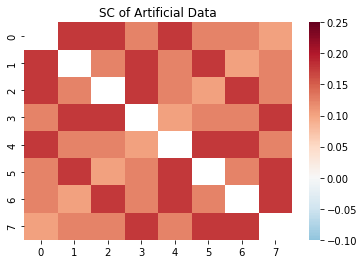

In [6]:
print(max(abs(torch.linalg.eig(SC_mtx_norm).eigenvalues)))
mask = np.eye(num_regions)
sns.heatmap(Con_Mtx, mask = mask, center=0, cmap='RdBu_r', vmin=-0.1, vmax = 0.25)
plt.title("SC of Artificial Data")

In [7]:
#############################################
## Generating a Lead Field Matrix
#############################################

# Placing an EEG Electrode in the middle of each cube face. 
# Then electrode is equally distance from four courner on cube face squre.
# Assume no signal from further four points. 

Lead_Field = torch.tensor([[1,1,0,0,1,1,0,0],
                           [1,1,1,1,0,0,0,0],
                           [0,1,0,1,0,1,0,1],
                           [0,0,0,0,1,1,1,1],
                           [1,0,1,0,1,0,1,0],
                           [0,0,1,1,0,0,1,1]], dtype = torch.float)
LF_Norm = (1/torch.linalg.matrix_norm(Lead_Field, ord = 2)) * Lead_Field

paramsEEG.LF = LF_Norm

In [8]:
#############################################
## Generating a "Connectivity Matrix" for Channel Space
#############################################

## Generating a physically possible (in 3D Space) "Channel" Connectivity Matrix
# That is a theoretical matrix for the EEG SC to be fit to

# First, get face points on a cube and project onto a sphere
LF_square_points = torch.tensor([[0.,1.,0.],
                                 [0.,0.,1.],
                                 [-1.,0.,0.],
                                 [0.,0.,-1.],
                                 [1.,0.,0.],
                                 [0.,-1.,0.]])
# Note: this does nothing as the points are already on the r=1 sphere
LF_sphere_points = LF_square_points / torch.sqrt(torch.sum(torch.square(LF_square_points), axis = 1)).repeat(3, 1).t()


# Second, find the distance between all pairs of channel points
LF_dist_mtx = torch.zeros(num_channels, num_channels)
for x in range(num_channels):
    for y in range(num_channels):
        LF_dist_mtx[x,y]= torch.linalg.norm(LF_sphere_points[x,:] - LF_sphere_points[y,:])

# Third, Structural Connectivity defined to be 1/dist and remove self-connection values
LF_SC_mtx = 1/LF_dist_mtx
for z in range(num_channels):
    LF_SC_mtx[z,z] = 0.0

# Fourth, Normalize the matrix
LF_SC_mtx_norm = (1/torch.linalg.matrix_norm(LF_SC_mtx, ord = 2)) * LF_SC_mtx
LF_Con_Mtx = LF_SC_mtx_norm

## Defining the CNMM Model

In [9]:
## The Multi-Modal Model

class mmModel(torch.nn.Module):
    def __init__(self):
        super(mmModel, self).__init__()
        
        self.nodes = RWW_Layer(num_regions, paramsNode, Con_Mtx, dist_mtx, step_size)
        self.eeg = EEG_Layer(num_regions, paramsEEG, num_channels)
        self.bold = BOLD_Layer(num_regions, paramsBOLD)
        
        self.next_start_state = init_state
        
    def forward(self, debug = False):
        
        self.step_size = step_size #in msec
        self.sim_len = sim_len #in msec
        
        node_states, node_history = self.nodes.forward(self.next_start_state[:, 0:2], self.sim_len, startGradAtStep, debug = debug)
        EEG_history = self.eeg.forward(self.step_size, self.sim_len, node_history, startGradAtStep)
        BOLD_states, BOLD_history = self.bold.forward(self.next_start_state[:, 2:6], self.step_size, self.sim_len, node_history[:,:,0], startGradAtStep)
        self.next_start_state = torch.cat((node_states, BOLD_states), dim=1).detach()
        
        return node_history, EEG_history, BOLD_history
        

## Defining the Objective Function

In [10]:
## Written in such as way as to be able to adjust the relative importance of components that make up the objective function.
## Also, written in such a way as to be able to track and plot indiviual components losses over time. 

class objectiveFunction():
    def __init__(self):
        # Weights of Objective Function Components
        self.S_E_mean_weight = 1
        self.S_I_mean_weight = 0 # Not Currently Used
        self.EEG_PSD_weight = 0 # Not Currently Used
        self.EEG_FC_weight = 0 # Not Currently Used
        self.BOLD_PSD_weight = 0 # Not Currently Used
        self.BOLD_FC_weight = 0 # Not Currently Used
        
        # Functions of the various Objective Function Components
        self.S_E_mean = meanVariableLoss(num_regions, varIdx = 0, targetValue = torch.tensor([0.164]))
        #self.S_I_mean = meanVariableLoss(...) # Not Currently Used
        #self.EEG_PSD = powerSpectrumLoss(num_channels, varIdx = 0, sampleFreqHz = 1000*(1/step_size), targetValue = targetEEG)
        #self.EEG_FC = functionalConnectivityLoss(...) # Not Currently Used
        #self.BOLD_PSD = powerSpectrumLoss(...) # Not Currently Used
        #self.BOLD_FC = functionalConnectivityLoss(num_regions, varIdx = 4, targetValue = SC_mtx_norm)
                
    def calcTotalLoss(self, node_history, EEG_history, BOLD_history, returnLossComponents = False):
        
        S_E_mean_loss = self.S_E_mean.calcLoss(node_history) 
        S_I_mean_loss = torch.tensor([0]) #self.S_I_mean.calcLoss(node_history)
        EEG_PSD_loss = torch.tensor([0]) #self.EEG_PSD.calcLoss(EEG_history) 
        EEG_FC_loss = torch.tensor([0]) #self.EEG_FC.calcLoss(EEG_history)
        BOLD_PSD_loss = torch.tensor([0]) #self.BOLD_PS.calcLoss(BOLD_history)
        BOLD_FC_loss = torch.tensor([0]) #self.BOLD_FC.calcLoss(BOLD_history)
                
        totalLoss = self.S_E_mean_weight*S_E_mean_loss + self.S_I_mean_weight*S_I_mean_loss \
                  + self.EEG_PSD_weight*EEG_PSD_loss   + self.EEG_FC_weight*EEG_FC_loss \
                  + self.BOLD_PSD_weight*BOLD_PSD_loss + self.BOLD_FC_weight*BOLD_FC_loss
                 
        if returnLossComponents:
            return totalLoss, (S_E_mean_loss.item(), S_I_mean_loss.item(), EEG_PSD_loss.item(), EEG_FC_loss.item(), BOLD_PSD_loss.item(), BOLD_FC_loss.item())
        else:
            return totalLoss

## Training The Model

In [11]:
model = mmModel()
TotalLossFn = objectiveFunction()

In [12]:
print(list(model.named_parameters()))

[('nodes.J', Parameter containing:
tensor([0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500],
       requires_grad=True))]


In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

In [14]:
LossComp = list()

J_values = list()

epochs = 20

for i in range(epochs):
    print(i)
    
    node_history, EEG_history, BOLD_history = model.forward()
    totalLoss, lossComponents = TotalLossFn.calcTotalLoss(node_history[skip_trans:,:,:], EEG_history[skip_trans:,:,:], BOLD_history[skip_trans:,:,:], returnLossComponents = True)
    print("totalLoss = ", totalLoss.item())
    
    optimizer.zero_grad()
    totalLoss.backward()
    optimizer.step()
    
    LossComp.append(lossComponents)
    J_values.append(model.nodes.J.detach().clone().numpy())

    
    print("J values = ", model.nodes.J.detach().clone().numpy())


0
totalLoss =  0.4572315216064453
J values =  [0.24999914 0.24999914 0.24999914 0.24999914 0.24999914 0.24999914
 0.24999914 0.24999914]
1
totalLoss =  0.4484558403491974
J values =  [0.35012966 0.3501265  0.35011446 0.35012358 0.3501331  0.35011145
 0.35011697 0.35011926]
2
totalLoss =  0.4380488693714142
J values =  [0.45048022 0.450471   0.45044586 0.45046017 0.4504709  0.4504535
 0.45045704 0.45045552]
3
totalLoss =  0.4267691671848297
J values =  [0.5511347  0.5511201  0.55106944 0.5511025  0.5511191  0.5510997
 0.5510909  0.55109227]
4
totalLoss =  0.4160443842411041
J values =  [0.6521646  0.6521538  0.65209347 0.65212727 0.6521574  0.6521486
 0.6521244  0.6520931 ]
5
totalLoss =  0.4019414782524109
J values =  [0.75367475 0.753638   0.7535964  0.75363904 0.75367504 0.75367904
 0.75364715 0.75358266]
6
totalLoss =  0.38725391030311584
J values =  [0.8557625  0.8557081  0.855678   0.855727   0.85576874 0.8557791
 0.85574347 0.85565734]
7
totalLoss =  0.3702915906906128
J values =

Text(0.5, 1.0, 'Total Loss over Training Epochs')

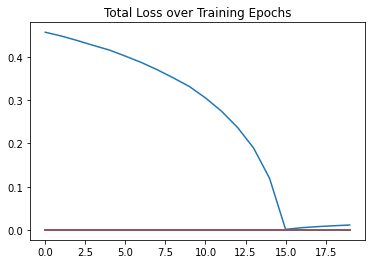

In [15]:
plt.plot(LossComp)
plt.title("Total Loss over Training Epochs")

Text(0.5, 1.0, 'J_{i} Values Changing Over Training Epochs')

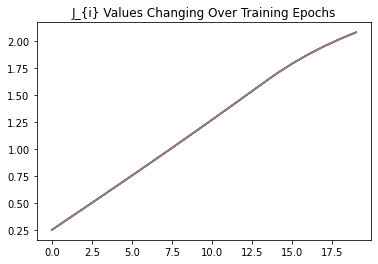

In [16]:
plt.plot(J_values)
plt.title("J_{i} Values Changing Over Training Epochs")

### Plots of S_E and S_I After Training

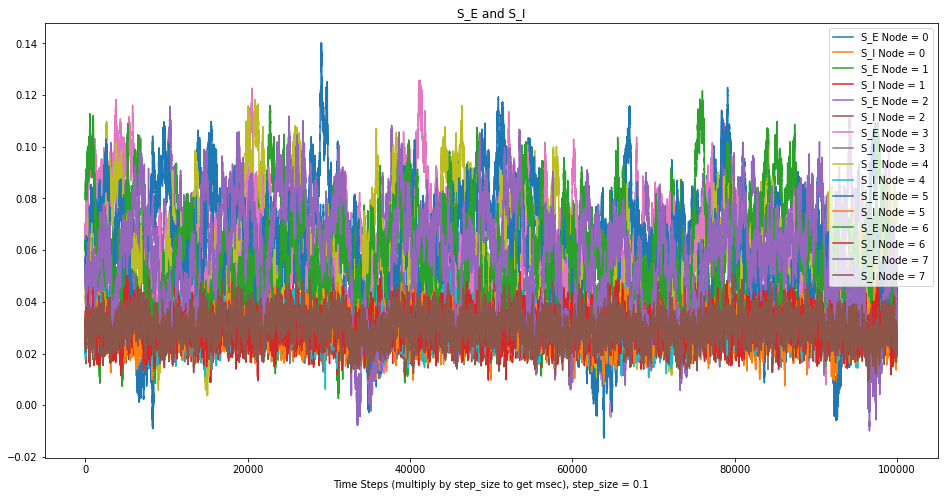

In [17]:
plt.figure(figsize = (16, 8))
plt.title("S_E and S_I")
for n in range(num_regions):
    plt.plot(node_history.detach()[:,n,0], label = "S_E Node = " + str(n))
    plt.plot(node_history.detach()[:,n,1], label = "S_I Node = " + str(n))

plt.xlabel('Time Steps (multiply by step_size to get msec), step_size = ' + str(step_size))
plt.legend()

### Plots of EEG PSD

Text(0.5, 1.0, 'Simulated EEG PSD: After Training')

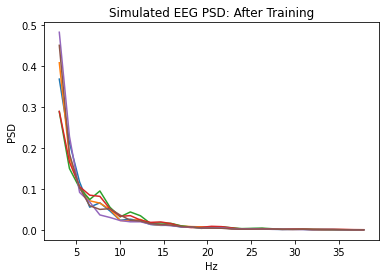

In [18]:
sampleFreqHz = 1000*(1/step_size)
sdAxis, sdValues = powerSpectrumLoss.calcPSD(EEG_history[skip_trans:,:,0], sampleFreqHz, minFreq = 2, maxFreq = 40)
sdAxis_dS, sdValues_dS = powerSpectrumLoss.downSmoothPSD(sdAxis, sdValues, 32)
sdAxis_dS, sdValues_dS_scaled = powerSpectrumLoss.scalePSD(sdAxis_dS, sdValues_dS)

plt.figure()
plt.plot(sdAxis_dS, sdValues_dS_scaled.detach())
plt.xlabel('Hz')
plt.ylabel('PSD')
plt.title("Simulated EEG PSD: After Training")

### Plots of BOLD FC

torch.Size([95000, 8])


<AxesSubplot:title={'center':'Simulated BOLD FC: After Training'}>

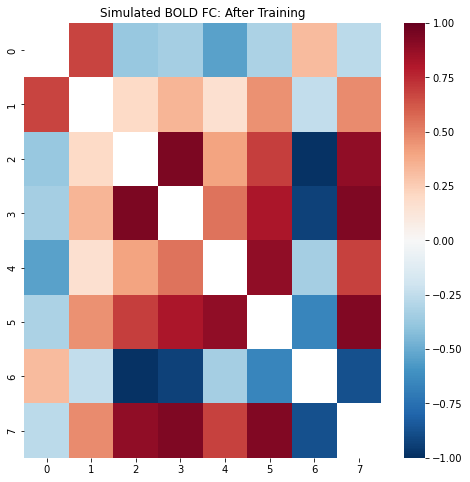

In [19]:
print(BOLD_history[skip_trans:, :, 4].shape)
sim_FC = functionalConnectivityLoss.calcFC(BOLD_history[:, :, 4]).detach()

plt.figure(figsize = (8, 8))
plt.title("Simulated BOLD FC: After Training")
mask = np.eye(num_regions)
sns.heatmap(sim_FC, mask = mask, center=0, cmap='RdBu_r', vmin=-1.0, vmax = 1.0)